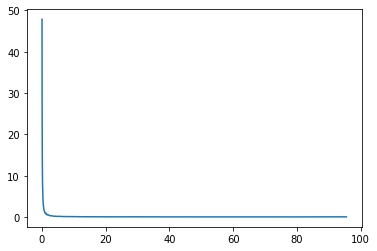

FOR THE FAST SOLAR WINDS

The breakpoints are located at:  [-0.98  1.98]


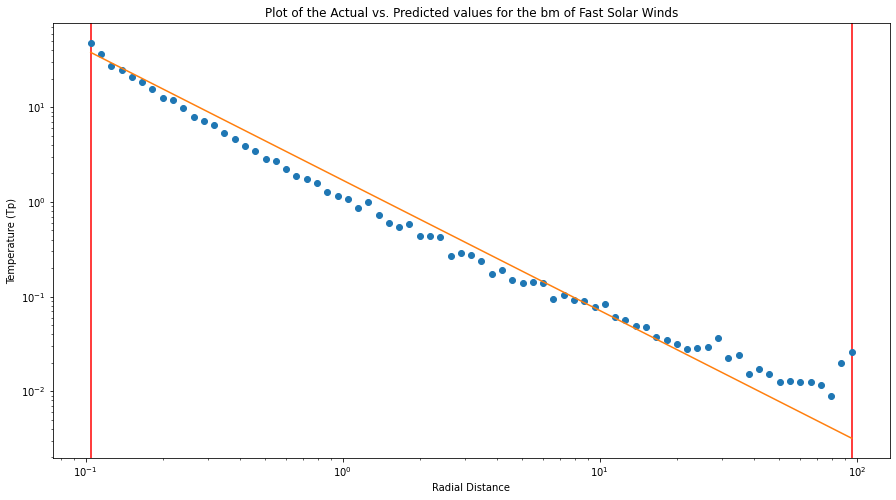

Chi-squared statistic: 13.0024
Does the model fit the data well? True
Slopes: [-1.37671347]
Intercepts: [0.23019375]
p value:   0.9999999999999991

FOR THE MEDIUM SOLAR WINDS

The breakpoints are located at:  [-0.98  1.98]


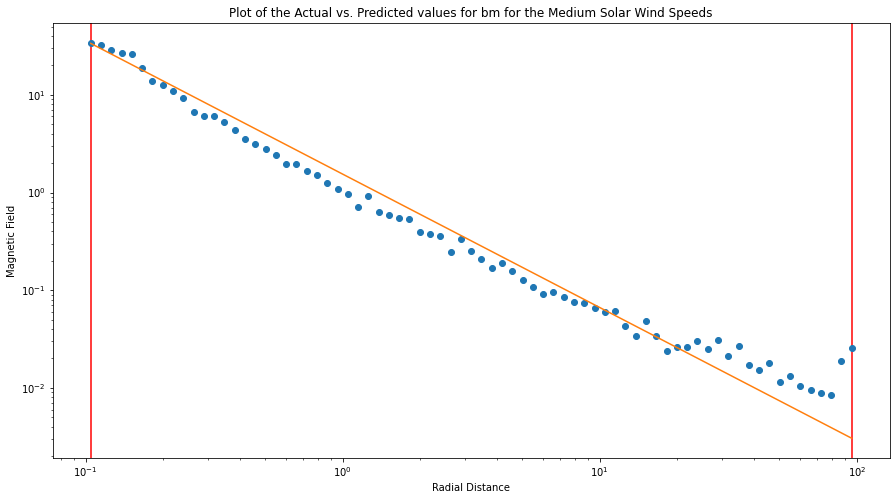

Chi-squared statistic: 10.1586
Does the model fit the data well? True
Slopes: [-1.36553313]
Intercepts: [0.18827946]

FOR THE SLOW SOLAR WINDS

The breakpoints are located at:  [-0.98  1.98]


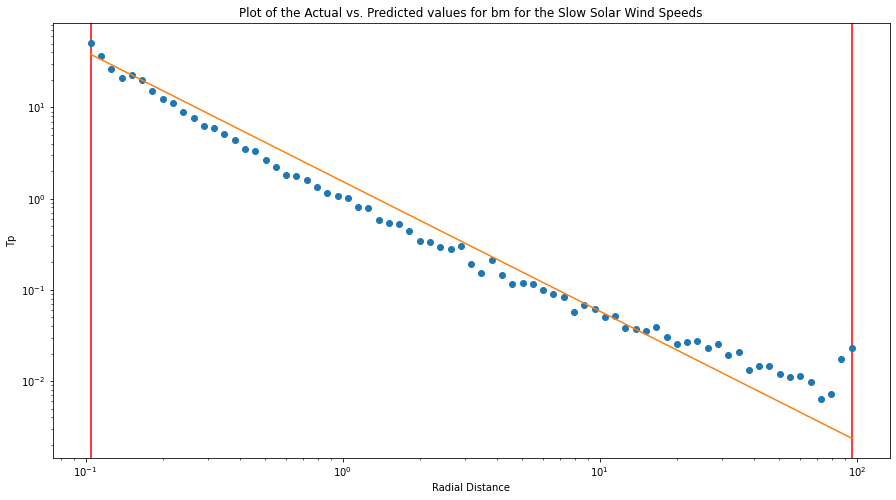

Chi-squared statistic: 16.4180
Does the model fit the data well? True
Slopes: [-1.42169362]
Intercepts: [0.18884284]



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import chi2
import pwlf
import math 

# Load and preprocess data
df = pd.read_pickle("all_spcaecraft_data_scaled_v2024.05.p")
df.dropna(subset=["sc_r", "vp_m"], inplace=True)
df = df[df["vp_m"] > 0]
df = df[df["bm"] > 0]

# Define bins and calculate geometric midpoints
bins = np.logspace(np.log10(0.1), np.log10(100), 76)
labels = range(len(bins) - 1)
df['bins'] = pd.cut(df['sc_r'], bins=bins, include_lowest=True, labels=labels)
mid_points = np.sqrt(bins[:-1] * bins[1:])

# Calculate percentile cutoffs within each bin
percentile_cutoffs = df.groupby('bins')['vp_m'].quantile([0.30, 0.40]).unstack()

# Rename columns for clarity
percentile_cutoffs.columns = ['p30', 'p40']

# Merge percentile cutoffs into the main DataFrame
df = df.join(percentile_cutoffs, on='bins')

# Label data with wind speed categories
conditions = [
    df['vp_m'] <= df['p30'],
    (df['vp_m'] > df['p30']) & (df['vp_m'] <= df['p40']),
    df['vp_m'] > df['p40']
]
choices = ['slow', 'medium', 'fast']
df['wind_speed_category'] = np.select(conditions, choices, default='fast')

# Filter out rows with NaN means before plotting or modeling
df.dropna(subset=['p30', 'p40'], inplace=True)

mean_bm = df.groupby(['bins', 'wind_speed_category'])['bm'].mean().unstack()

# Create lists for the average Tp_m values per bin for each category
bm_slow = mean_bm['slow'].tolist()
bm_medium = mean_bm['medium'].tolist()
bm_fast = mean_bm['fast'].tolist()

# Convert mid_points to a list
mid_points_list = mid_points.tolist()


plt.plot(mid_points_list, bm_fast)
plt.show()

# Function to calculate weights (inverse of the standard deviation in each bin)
def calculate_weights(category):
    weights_1 = df[df['wind_speed_category'] == category].groupby('bins')['bm'].size()
    total = df[df['wind_speed_category'] == category].groupby('bins')['bm'].count()
    weights_2 = np.sqrt(weights_1) / total
    #weights_2 = np.sqrt(weights_1)
    weights_2 = weights_2.fillna(0).tolist()
    # Normalize weights
    return weights_2
    #return [w / max(weights_1) for w in weights_2]  

# Function to compute the Chi-squared statistic for each model
def chi_squared_test(observed, predicted, degrees_freedom, alpha=0.05):

    squared_residuals = [(obs - pred)**2 / pred for obs, pred in zip(observed, predicted)]
    chi_squared_stat = sum(squared_residuals)
    
    p_value = 1 - chi2.cdf(chi_squared_stat, degrees_freedom)
    
    if p_value < alpha:
        fit_result = False
    else:
        fit_result = True
    
    return chi_squared_stat, p_value, fit_result

def clean_lists(mid_points_list, bm_fast, weight_fast):

    valid_mid_points = []
    valid_bm_fast = []
    valid_weights = []

    for mid_point, bm, weight in zip(mid_points_list, bm_fast, weight_fast):
        try:
            log_mid_point = np.log10(mid_point)
            log_bm = np.log10(bm)
            # Check if log values are finite (not inf or NaN)
            if np.isfinite(log_mid_point) and np.isfinite(log_bm):
                # If both values are valid, append to the new lists
                valid_mid_points.append(log_mid_point)
                valid_bm_fast.append(log_bm)
                valid_weights.append(weight)
        except (ValueError, OverflowError):
            # Skip invalid values
            continue
    
    return valid_mid_points, valid_bm_fast, valid_weights


# Calculate weights for each category
weights_slow = calculate_weights('slow')
weights_medium = calculate_weights('medium')
weights_fast = calculate_weights('fast')

# FOR THE FAST SOLAR WINDS 
print("FOR THE FAST SOLAR WINDS")
print()

# # Remove the outliers (i.e. last two points and first point) 
# highest_value_x = max(mid_points_list)
# highest_value_y_index = mid_points_list.index(highest_value_x)
# Tp_m_fast.pop(highest_value_y_index)
# mid_points_list.remove(highest_value_x)
# weights_fast.pop(highest_value_y_index)

# second_highest_value_x = max(mid_points_list)
# second_highest_value_y_index = mid_points_list.index(second_highest_value_x)
# Tp_m_fast.pop(second_highest_value_y_index)
# mid_points_list.remove(second_highest_value_x)
# weights_fast.pop(second_highest_value_y_index)

# lowest_value_x = min(mid_points_list)
# lowest_value_y_index = mid_points_list.index(lowest_value_x)
# Tp_m_fast.pop(lowest_value_y_index)
# mid_points_list.remove(lowest_value_x)
# weights_fast.pop(lowest_value_y_index)

log10_mid_points_list, log10_bm_fast, weights_fast = clean_lists(mid_points_list, bm_fast, weights_fast)

my_pwlf = pwlf.PiecewiseLinFit(log10_mid_points_list, log10_bm_fast, weights=weights_fast)
breaks = my_pwlf.fit(1)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, bm_fast, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Temperature (Tp)")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for the bm of Fast Solar Winds")
plt.savefig('fast_solar_winds_Tp_m.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_fast = bm_fast
predicted_fast = 10**predicted_y_fast
degrees_freedom = len(observed_fast) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_fast, predicted_fast, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print("p value:  ", p_value)
print()

fast_winds_data = {'Radial Distance (AU)': mid_points_list, 'Magnetic Field (nT)': bm_fast}
fast_winds_df = pd.DataFrame(fast_winds_data)
fast_winds_df.to_csv('fast_solar_winds_bm.csv', index=False)

# FOR THE MEDIUM SOLAR WINDS 
print("FOR THE MEDIUM SOLAR WINDS")
print()

# # Remove the outliers (i.e. last two points and first two points)
# vp_m_medium.pop(highest_value_y_index)
# vp_m_medium.pop(second_highest_value_y_index)
# weights_medium.pop(highest_value_y_index)
# weights_medium.pop(second_highest_value_y_index)

# vp_m_medium.pop(lowest_value_y_index)
# weights_medium.pop(lowest_value_y_index)

# second_lowest_value_x = min(mid_points_list)
# second_lowest_value_y_index = mid_points_list.index(second_lowest_value_x)
# vp_m_medium.pop(second_lowest_value_y_index)
# mid_points_list.remove(second_lowest_value_x)
# weights_medium.pop(second_lowest_value_y_index)

log10_mid_points_list, log10_bm_medium, weights_medium = clean_lists(mid_points_list, bm_medium, weights_medium)

my_pwlf = pwlf.PiecewiseLinFit(log10_mid_points_list, log10_bm_medium, weights=weights_medium)
breaks = my_pwlf.fit(1)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, bm_medium, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Magnetic Field")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for bm for the Medium Solar Wind Speeds")
plt.savefig('medium_solar_winds_bm.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_medium = bm_medium
predicted_medium = 10**predicted_y_fast
degrees_freedom = len(observed_medium) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_medium, predicted_medium, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

medium_winds_data = {'Radial Distance (AU)': mid_points_list, 'Magnetic Field (nT)': bm_medium}
medium_winds_df = pd.DataFrame(medium_winds_data)
medium_winds_df.to_csv('medium_solar_winds_bm.csv', index=False)

# FOR THE SLOW SOLAR WINDS 
print("FOR THE SLOW SOLAR WINDS")
print()

# Remove the lat two points and the first two points
# vp_m_slow.pop(highest_value_y_index)
# vp_m_slow.pop(second_highest_value_y_index)
# weights_slow.pop(highest_value_y_index)
# weights_slow.pop(second_highest_value_y_index)

# vp_m_slow.pop(lowest_value_y_index)
# weights_slow.pop(lowest_value_y_index)
# vp_m_slow.pop(second_lowest_value_y_index)
# weights_slow.pop(second_lowest_value_y_index)

# Generate the model using a package implementing curve_fit
log10_mid_points_list, log10_bm_slow, weights_slow = clean_lists(mid_points_list, bm_slow, weights_slow)
my_pwlf = pwlf.PiecewiseLinFit(log10_mid_points_list, log10_bm_slow, weights=weights_slow)
breaks = my_pwlf.fit(1)
print("The breakpoints are located at: ", breaks)

predicted_y_fast = my_pwlf.predict(np.log10(mid_points_list))

plt.figure(figsize=(15, 8)) 
plt.xscale("log")
plt.yscale("log")
for b in breaks:
    plt.axvline(10**b, color='r')
plt.plot(mid_points_list, bm_slow, 'o')
plt.plot(mid_points_list, 10**predicted_y_fast, '-')
plt.ylabel("Tp")
plt.xlabel("Radial Distance")
plt.title("Plot of the Actual vs. Predicted values for bm for the Slow Solar Wind Speeds")
plt.savefig('slow_solar_winds_Tp.png', dpi=100, bbox_inches='tight')
plt.show()

slopes = my_pwlf.slopes
intercepts = my_pwlf.intercepts
observed_slow = bm_slow
predicted_slow = 10**predicted_y_fast
degrees_freedom = len(observed_slow) - len(slopes) - len(intercepts) - 1  
chi_squared_stat, p_value, fit_result = chi_squared_test(observed_slow, predicted_slow, degrees_freedom)
print(f"Chi-squared statistic: {chi_squared_stat:.4f}")
print(f"Does the model fit the data well? {fit_result}")
print("Slopes:", slopes)
print("Intercepts:", intercepts)
print()

slow_winds_data = {'Radial Distance': mid_points_list, 'Speed': bm_slow}
slow_winds_df = pd.DataFrame(slow_winds_data)
slow_winds_df.to_csv('slow_solar_winds_Tp.csv', index=False)


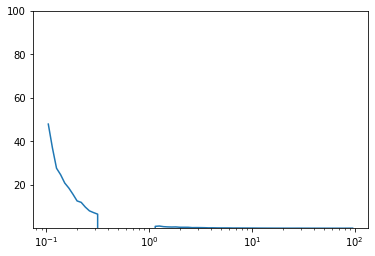

In [5]:
plt.plot(mid_points_list, bm_fast)
plt.ylim(0.1,100)
plt.xscale("log")
plt.xscale("log")
plt.show()